In [1]:
# ! pip install geopandas
# ! pip install pandas

In [13]:
import pandas as pd
import geopandas as gpd
import os
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [3]:
# %matplotlib notebook

In [4]:
data_path = './data/'
assert os.path.exists(data_path)

temp_by_city_filepath = data_path + 'GlobalLandTemperaturesByCity.csv'
temp_by_country_filepath = data_path + 'GlobalLandTemperaturesByCountry.csv'
temp_by_major_city_filepath = data_path + 'GlobalLandTemperaturesByMajorCity.csv'
temp_by_state_filepath = data_path + 'GlobalLandTemperaturesByState.csv'
temp_filepath = data_path + 'GlobalTemperatures.csv'

carbon_emissions_filepath = data_path + 'MER_T12_06.csv'
filepaths = [
    temp_by_city_filepath, 
    temp_by_country_filepath, 
    temp_by_major_city_filepath, 
    temp_by_state_filepath, 
    temp_filepath, 
    carbon_emissions_filepath
]

for fp in filepaths:
    if not os.path.exists(fp):
        raise RuntimeError(f'Could not locate filepath: {fp}')

In [5]:
temp_fp = temp_by_country_filepath
temp_frame = pd.read_csv(temp_fp)

In [6]:
carbon_emissions_frame = pd.read_csv(carbon_emissions_filepath)

In [7]:
temp_frame.head(5)

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
0,1743-11-01,4.384,2.294,Åland
1,1743-12-01,NaN,NaN,Åland
2,1744-01-01,NaN,NaN,Åland
3,1744-02-01,NaN,NaN,Åland
4,1744-03-01,NaN,NaN,Åland


In [8]:
def change_country_name(temp_frame, current_name, desired_name):

    print(f"Changing: {current_name} ==> {desired_name}")
    
    def change(current_country):

        if current_country == current_name:
            return desired_name
        else:
            return current_country

    temp_frame['Country'] = temp_frame['Country'].apply(change)
    return temp_frame

In [9]:
temp_frame = change_country_name(temp_frame, 'United States', 'United States of America')
temp_frame = change_country_name(temp_frame, 'Congo (Democratic Republic Of The)', 'Dem. Rep. Congo')
temp_frame = change_country_name(temp_frame, 'Central African Republic', 'Central African Rep.')

Changing: United States ==> United States of America
Changing: Congo (Democratic Republic Of The) ==> Dem. Rep. Congo
Changing: Central African Republic ==> Central African Rep.


In [10]:
def get_country_average_temperature(frame, year):

    yearly_data = frame[frame.dt.str.startswith(str(year))]
    country_yearly_data = yearly_data.groupby("Country").agg({'AverageTemperature': "mean"})

    return country_yearly_data

In [11]:
def plot_year(frame, year):

    yearly_data = get_country_average_temperature(frame, year)

    # Load the world shapefile from Geopandas datasets
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

    # Merge the world shapefile with the temperature data
    world = world.merge(yearly_data, left_on='name', right_on='Country')

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot the world map with temperature data
    world.boundary.plot(ax=ax, linewidth=0.5, color='k')
    world.plot(column='AverageTemperature', cmap='coolwarm', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

    # Set the title and show the plot
    ax.set_title(f'Temperature by Country ({year})')
    plt.show()

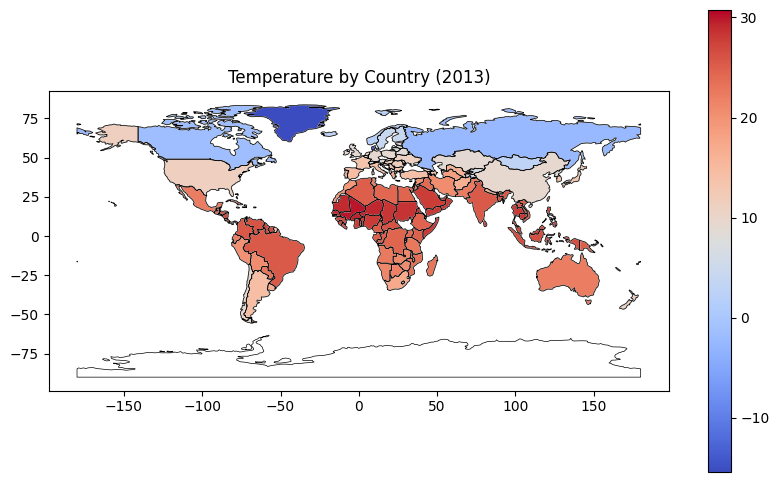

In [12]:
plot_year(temp_frame, 2013)

In [21]:
def animate_temperatures(frame):

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))
    years = sorted(list(set([date_list[0] for date_list in frame.dt.str.split('-')])))
    
    # Load the world shapefile from Geopandas datasets
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

    def animate(frame_num):

        print(f"Animating frame: {frame_num} / {len(years)}", end='\r')

        year = years[frame_num]
        yearly_data = get_country_average_temperature(frame, year)

        ax.clear()

        # Set the title and show the plot
        ax.set_title(f'Temperature by Country ({year})')

        # Merge the world shapefile with the temperature data
        world_year = world.merge(yearly_data, left_on='name', right_on='Country')

        # Plot the world map with temperature data
        world_year.boundary.plot(ax=ax, linewidth=0.5, color='k')
        world_year.plot(column='AverageTemperature', cmap='coolwarm', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
            

    ani = FuncAnimation(fig, animate, frames=len(years), interval=500)
    HTML(ani.to_jshtml())
    
    


KeyboardInterrupt: 

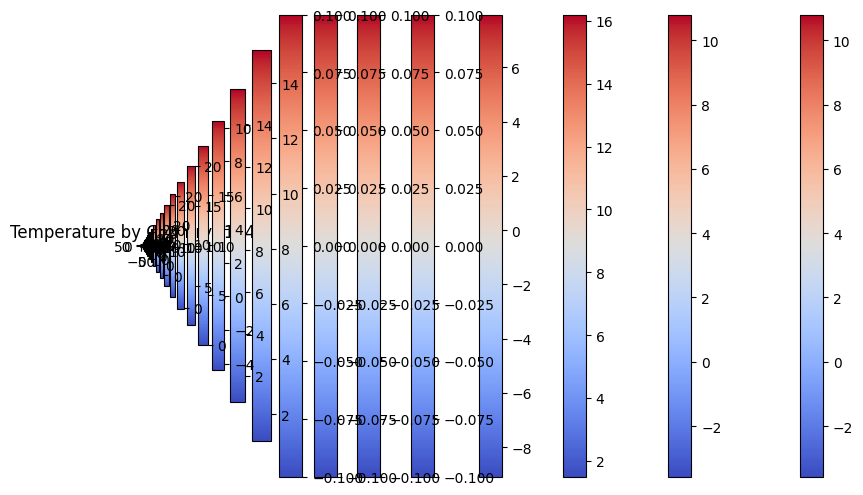

In [22]:
animate_temperatures(temp_frame)